# Top2Vec experiment to find best embedding model and number of topics
based on 1st starting posts in "Everything else" Russian women forum eva.ru

In [ ]:
!pip install top2vec[sentence_encoders]
#!pip install top2vec[sentence_transformers] breaks plotly.express

In [ ]:
!pip install plotly==5.5.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
import plotly.express as px
import plotly.graph_objects as go

In [5]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.3 MB/s eta 0:00:011
     |████████████████████████████████| 8.2 MB 7.0 MB/s 


In [6]:
import pymorphy2

In [7]:
from top2vec import Top2Vec
np.random.seed(42)

In [8]:
import gensim.corpora as corpora
from gensim.utils import tokenize
from gensim.models import CoherenceModel

In [9]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

In [10]:
#Saving into log (Excel file)
import openpyxl 
def SaveToExperimentLog(Experiments_file, LogEntry, data):
    book = openpyxl.load_workbook(Experiments_file)
    writer = pd.ExcelWriter(Experiments_file, engine='openpyxl') 
    writer.book = book

    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    data.to_excel(writer, LogEntry[0:29],index=False)

    writer.save()
    writer.close()

def SaveChartToExperimentLog(Experiments_file, LogEntry, Start_Position, Step, lst_img_filenames):
    book = openpyxl.load_workbook(Experiments_file)
    ws = book[LogEntry[0:29]]
    p = Start_Position + 10
    for f in lst_img_filenames:
        img = openpyxl.drawing.image.Image(f)
        ws.add_image(img)
        position = p
        img.anchor = 'A%s'%p
        p = p + Step

    book.save(Experiments_file)    

In [11]:
#Topics Distance map visualization
#Thanks to https://github.com/MaartenGr/BERTopic/tree/master/bertopic/plotting




def _plotly_topic_visualization(data: pd.DataFrame,
                                width: int,
                                height: int):
    """ Create plotly-based visualization of topics with a slider for topic selection """
    topic_list = data['Topic'].tolist()
    def get_color(topic_selected):
        marker_color = ['red' if topic == topic_selected else '#B0BEC5' for topic in topic_list]
        return [{'marker.color': [marker_color]}]

    # Prepare figure range
    x_range = (data.x.min() - abs((data.x.min()) * .15), data.x.max() + abs((data.x.max()) * .15))
    y_range = (data.y.min() - abs((data.y.min()) * .15), data.y.max() + abs((data.y.max()) * .15))

    # Plot topics
    fig = px.scatter(data, x='x', y='y', size='Size', size_max=40, template='simple_white', labels={'x': '', 'y': ''},hover_data=['Topic','Words','Size'])

    fig.update_traces(marker=dict(color='#B0BEC5', line=dict(width=2, color='DarkSlateGrey')))

    # Update hover order
    
    fig.update_traces(hovertemplate='<br>'.join(['<b>Topic %{customdata[0]}</b>',
                                                 'Words: %{customdata[1]}',
                                                 'Size: %{customdata[2]}']))

    # Create a slider for topic selection
    steps = [dict(label=f'Topic {topic}', method='update', args=get_color(topic)) for topic in topic_list]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
        title={
            'text': '<b>Topics Distance Map',
            'y': .95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color='Black')
        },
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor='white',
            font_size=16,
            font_family='Rockwell'
        ),
        xaxis={'visible': False},
        yaxis={'visible': False},
        sliders=sliders
    )

    # Update axes ranges
    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)

    # Add grid in a 'plus' shape
    fig.add_shape(type='line',
                  x0=sum(x_range) / 2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color='#CFD8DC', width=2))
    fig.add_shape(type='line',
                  x0=x_range[0], y0=sum(y_range) / 2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color='#9E9E9E', width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text='D1', showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text='D2', showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig

def topics_distance_map(model, top_n_topics = None, reduced=False,  width = 650, height = 650, topic_names: list = None):
  """ Visualize topics, their sizes, and their corresponding words
  This visualization is highly inspired by LDAvis, a great visualization
  technique typically reserved for LDA.
  Arguments:
        model: A fitted Top2Vec instance.
        top_n_topics: Only select the top n most frequent topics
        reduced: Original topics are used by default. 
                 If True the reduced topics will be used.        
        width: The width of the figure.
        height: The height of the figure.
    Usage:
    To visualize the topics simply run:
    ```python
    topic_model.visualize_topics()
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_topics()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/viz.html"
    style="width:1000px; height: 680px; border: 0px;""></iframe>
  """


  # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=top_n_topics)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

  topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)


  if reduced:
    topic_vectors=model.topic_vectors_reduced
  else:
    topic_vectors=model.topic_vectors

  if topic_names:
    words = topic_names
  else:
    words = ['_'.join([word for word in x[:3]]) for x in topic_words]

  #topics vectors into 2D via cosine similarity 
  embeddings = MinMaxScaler().fit_transform(topic_vectors)
  embeddings = UMAP(n_neighbors=2, n_components=2,metric='cosine',random_state=42).fit_transform(embeddings)

  data = pd.DataFrame({'x': embeddings[0:, 0], 'y': embeddings[0:, 1], 'Topic': topic_nums, 'Words': words, 'Size': topic_sizes})
  if top_n_topics is not None:
    data=data.head(top_n_topics)
  return _plotly_topic_visualization(data, width, height)

In [12]:
#heatmap of the topic's similarity matrix
#Thanks to https://github.com/MaartenGr/BERTopic/tree/master/bertopic/plotting

def visualize_heatmap(model,
                      top_n_topics: int = None,
                      n_clusters: int = None,
                      reduced=False,
                      width: int = 800,
                      height: int = 800,
                      topic_names: list = None) -> go.Figure:
    """ Visualize a heatmap of the topic's similarity matrix
    Based on the cosine similarity matrix between topic embeddings,
    a heatmap is created showing the similarity between topics.
    Arguments:
        model: A fitted Top2Vec instance.
        top_n_topics: Only select the top n most frequent topics.
        n_clusters: Create n clusters and order the similarity
                    matrix by those clusters.
        reduced: Original topics are used by default. 
                 If True the reduced topics will be used.
        width: The width of the figure.
        height: The height of the figure.
    Returns:
        fig: A plotly figure
    Usage:
    To visualize the similarity matrix of
    topics simply run:
    ```python
    topic_model.visualize_heatmap()
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_heatmap()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/heatmap.html"
    style="width:1000px; height: 720px; border: 0px;""></iframe>
    """

    # Extract topic words, sizes and embeddings
    if ((model.topic_vectors_reduced is None) & (reduced)):
      topic_mapping = model.hierarchical_topic_reduction(num_topics=top_n_topics)

    topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
    topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

    if reduced:
      topic_vectors=model.topic_vectors_reduced
    else:
      topic_vectors=model.topic_vectors


    if top_n_topics is not None:
      embeddings = topic_vectors[0:top_n_topics]
      topics=topic_nums[0:top_n_topics]
    else:
      embeddings = topic_vectors
      topics=topic_nums


    # Order heatmap by similar clusters of topics
    if n_clusters:
        if n_clusters >= len(topics):
            raise ValueError("Make sure to set `n_clusters` lower than "
                             "the total number of unique topics.")

        #embeddings = embeddings[[topic + 1 for topic in topics]]
        distance_matrix = cosine_similarity(embeddings)
        Z = linkage(distance_matrix, 'ward')
        clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

        # Extract new order of topics
        mapping = {cluster: [] for cluster in clusters}
        for topic, cluster in zip(topics, clusters):
            mapping[cluster].append(topic)
        mapping = [cluster for cluster in mapping.values()]
        sorted_topics = [topic for cluster in mapping for topic in cluster]
    else:
        sorted_topics = topics

    # Select embeddings
    indices = np.array([topics[topic] for topic in sorted_topics])
    embeddings = embeddings[indices]
    distance_matrix = cosine_similarity(embeddings)

    # Create nicer labels
    if topic_names:
      new_labels = topic_names
    else:
      new_labels = [[str(topic)]+ topic_words[topic] for topic in sorted_topics]
      new_labels = ["_".join([label for label in labels[:4]]) for labels in new_labels]
      new_labels = [label if len(label) < 30 else label[:27] + "..." for label in new_labels]

    fig = px.imshow(distance_matrix,
                    labels=dict(color="Similarity Score"),
                    x=new_labels,
                    y=new_labels,
                    color_continuous_scale='GnBu'
                    )

    fig.update_layout(
        title={
            'text': "<b>Similarity Matrix",
            'y': .95,
            'x': 0.55,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
    )
    fig.update_layout(showlegend=True)
    fig.update_layout(legend_title_text='Trend')
    return fig

In [13]:
#Topics Size WordMap
def topics_size_word_map(topic_size_dic, mask_image_file=None, width=1600, height=800, width_figsize=20, height_figsize=10):
  if mask_image_file:
    img_mask = np.array(Image.open(mask_image_file))
  else:
    img_mask = None
  wc = WordCloud(background_color="white", max_words=1000, mask=img_mask, width=width, height=height)
    
  #generate word cloud
  wc.generate_from_frequencies(topic_size_dic)

  # show
  plt.figure( figsize=(width_figsize,height_figsize) )
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()

  return wc

In [31]:
#Topics content wordmap
def topics_content_word_map(model,reduced=False, nrows=5, ncols=2,  width=1000, height=1000, width_figsize=10, height_figsize=20, topic_content: list = None, topic_names: list = None):

   # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=nrows*ncols)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)
  if topic_content:
    topic_words=topic_content
  else:
    topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё').replace('_',' ') for x in w] for w in topic_words]


  fig, axs = plt.subplots(nrows,ncols, figsize=(width_figsize, height_figsize))

  fig.tight_layout()

  axs = axs.ravel()
  for idx,t in enumerate(topic_nums):
    if idx>nrows*ncols-1:
      break
    wordmap_dict = dict(zip(topic_words[idx], word_scores[idx]))
    if topic_names:
      Title = '%s (%s)'%(topic_names[idx],topic_sizes[idx])
    else:
      Title = 'Topic %s (%s)'%(t,topic_sizes[idx])

    wc = WordCloud(background_color="white", max_words=1000, width=width, height=height)
    wc.generate_from_frequencies(wordmap_dict)
    axs[idx].imshow(wc)
    axs[idx].axis('off')
    axs[idx].title.set_text(Title)

  return fig

In [15]:
#Topics data in a form of pandas data frame
#lemmanization - normal form for topic name
morph = pymorphy2.MorphAnalyzer()
def lemmanized_first_word(text):
    words = text.split(',') # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)
        res.append(p[0].normal_form)
        
    return  set(res[0:1]).pop()
def topic_name(row):
    text = row['Words']        
    return  lemmanized_first_word(text)

def TopicsData (model):
  # model: A fitted Top2Vec instance.

  topic_words, word_scores,topic_nums = model.get_topics()
  topic_sizes, topic_nums = model.get_topic_sizes()
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]
  topics_df=pd.DataFrame({'Id':topic_nums.tolist(),
              'Size':topic_sizes.tolist(),
              'Words':[','.join(x) for x in topic_words],
              'Scores':word_scores.tolist()
              })
  topics_df['Name'] = topics_df.apply(topic_name,axis=1)

  return topics_df

def ReducedTopicsData (model,num_topics=15):
  # model: A fitted Top2Vec instance

  # Extract topic words, sizes etc
  topic_mapping = model.hierarchical_topic_reduction(num_topics=num_topics)


  topic_words_reduced, word_scores_reduced,topic_nums_reduced = model.get_topics(reduced=True)
  topic_sizes_reduced, topic_nums_reduced = model.get_topic_sizes(reduced=True)
  topic_words_reduced=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words_reduced]

  topics_reduced_df=pd.DataFrame({'Id':topic_nums_reduced.tolist(),
              'Size':topic_sizes_reduced.tolist(),
              'Words':[','.join(x) for x in topic_words_reduced],
              'Scores':word_scores_reduced.tolist(),
              'Mapping':topic_mapping
              })
  topics_reduced_df['Name'] = topics_reduced_df.apply(topic_name,axis=1)


  return topics_reduced_df
  
def Map_topics_and_reduced(topics_df, topics_reduced_df):
  d_topic_mapping={}
  for index, row in topics_reduced_df.iterrows():
    for v in row['Mapping']:
      d_topic_mapping[v]=row['Id'] 
  topics_df['Group'] = topics_df['Id'].map(d_topic_mapping)   
  topics_df = pd.merge(topics_df,reduced_topics_df[['Id','Size','Words','Scores','Name']], left_on='Group', right_on='Id', how='inner', suffixes=('', '_reduced'))
  topics_df=topics_df[['Id','Size','Words','Scores','Name','Group','Size_reduced','Words_reduced','Scores_reduced','Name_reduced']]
  topics_df.columns=['Id','Size','Words','Scores','Name','Group_Id','Size_reduced','Words_reduced','Scores_reduced','Name_reduced']
  return topics_df   

In [16]:
#Model score - coherence

def model_coherence(model, data, reduced=False,num_topics=15):
  # model: A fitted Top2Vec instance.
  # data used in the model (list of strings)
  # reduced: Original topics are used by default. 
  #          If True the reduced topics will be used.
  # num_topics is used only if reduced=True
  
  # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=num_topics)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_words=topic_words.tolist()
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

  tokenized = [s.split() for s in data]
  id2word = corpora.Dictionary(tokenized)
  corpus = [id2word.doc2bow(text) for text in tokenized]

  cm = CoherenceModel(topics=topic_words,texts=tokenized, corpus=corpus, dictionary=id2word, coherence='c_v')
  return cm.get_coherence()

In [17]:
#Experiment Set up - file names etc
Data = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Data/'

Chapter_Id=77

Images = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Images/'

#black&white image with background removed and set to white
##https://www9.lunapic.com/ can help with background
Mask_Image_filename='%s.png'%Chapter_Id
Mask_Image_full_filename=os.path.join(Images, Mask_Image_filename)

TopicsSizeWordCloud_filename = '%s_topics_size_wordcloud.png'%Chapter_Id
TopicsSizeWordCloud_full_filename=os.path.join(Images, TopicsSizeWordCloud_filename)

TopicsSizeWordCloud_filename_eng = '%s_topics_size_wordcloud_eng.png'%Chapter_Id
TopicsSizeWordCloud_full_filename_eng=os.path.join(Images, TopicsSizeWordCloud_filename_eng)

TopicsContentWordCloud_filename = '%s_topics_content_wordcloud.png'%Chapter_Id
TopicsContentWordCloud_full_filename=os.path.join(Images, TopicsContentWordCloud_filename)

TopicsContentWordCloud_filename_eng = '%s_topics_content_wordcloud_eng.png'%Chapter_Id
TopicsContentWordCloud_full_filename_eng=os.path.join(Images, TopicsContentWordCloud_filename_eng)

Heatmap_filename = '%s_heatmap.html'%Chapter_Id
Heatmap_full_filename=os.path.join(Images, Heatmap_filename)

Heatmap_filename_eng = '%s_heatmap_eng.html'%Chapter_Id
Heatmap_full_filename_eng=os.path.join(Images, Heatmap_filename_eng)

Distancemap_filename = '%s_distancemap.html'%Chapter_Id
Distancemap_full_filename=os.path.join(Images, Distancemap_filename)

Distancemap_filename_eng = '%s_distancemap_eng.html'%Chapter_Id
Distancemap_full_filename_eng=os.path.join(Images, Distancemap_filename_eng)

#Experiment
Experiments_file='/content/drive/MyDrive/Colab Notebooks/Projects/eva/ExperimentLogs/77_Top2Vec_TopicsModeling.xlsx'
Experiment_name='Top2Vec'

#Experiment can be continued from the lines in the configuration tab (Experiment_name) without results (NewExecution=False) or started from scratch ignoring previous results (NewExecution=True)
NewExecution=False

Models = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Models/ChapterTopics/'

## Experiment
Experiment is configured in an experiment log file (Excel file, in my case,  in different tabs)

In [20]:
Experiment = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_name)
Experiment['Status']=Experiment['Status'].apply(str)
Experiment.tail()

Trial  ... Status
0  77_Top2Vec1  ...   Done
1  77_Top2Vec2  ...   Done

[2 rows x 23 columns]

In [19]:
for index, row in Experiment.iterrows():
  print('Processing trial %s, model %s started...'%(row['Trial'], row['Model']))
  if (not(NewExecution) and row['Status']=='Done'):
    print('%s is already processed. Continue'%(row['Trial']))
    continue    

  #Experiment data
  Messages_full_filename=os.path.join(Data,row['Data'])
  df=pd.read_csv(Messages_full_filename, error_bad_lines=False, index_col=False)
  df[row['Column']]=df[row['Column']].str.lower()
  data = df[row['Column']].tolist()
  #Top2Vec can not process й and ё in Russina text even in unicode
  udata = [w.replace('й', 's').replace('Й', 'S').replace('ё', 'r').replace('Ё', 'R') for w in data]

  #Modeling
  model = Top2Vec(udata, workers=4, embedding_model=row['Model'])
  
  Model_full_filename=os.path.join(Models, row['Trial'])
  model.save(Model_full_filename)

  #Topics
  topics_df=TopicsData(model)
  #topics_df=Map_topics_and_reduced(topics_df, reduced_topics_df)

  #Similar topics
  tmp_df=topics_df.groupby(['Name'])['Name'].count().reset_index(name='cnt')
  Experiment.at[index,'Repeats']=len(tmp_df[tmp_df['cnt']>1])
  
  Experiment.at[index,'TopicsNum']=len(topics_df)
  
  #Scoring
  try:
    Experiment.at[index,'Score']=model_coherence(model, data)
  except:
    print('Can not calculate Score')
  SaveToExperimentLog(Experiments_file,row['Trial'],topics_df)

  #wordmap_df = topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
  #wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))
  #wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
  #wc.to_file(TopicsSizeWordCloud_full_filename)

  #fig = topics_content_word_map(model,reduced=False, nrows=4, ncols=3,  width=1000, height=1000, width_figsize=20, height_figsize=20)
  #fig.savefig(TopicsContentWordCloud_full_filename)

  #SaveChartToExperimentLog(Experiments_file, row['Trial'], len(topics_df)+10, 30, [TopicsSizeWordCloud_full_filename,TopicsContentWordCloud_full_filename])

  #Reduced Topics

  for i,r in enumerate([0.5,0.3,0.25,0.2,0.1]):
    
    num_reduced=int(len(topics_df)*r)
    if num_reduced<5:
      continue
    reduced_topics_df=ReducedTopicsData(model,num_reduced)
    Experiment.at[index,'ReducedTopicsNum'+str(r)]=len(reduced_topics_df)

    #Similar topics
    tmp_df=reduced_topics_df.groupby(['Name'])['Name'].count().reset_index(name='cnt')
    Experiment.at[index,'ReducedRepeats'+str(r)]=len(tmp_df[tmp_df['cnt']>1])

    #Scoring
    try:
      Experiment.at[index,'ScoreReduced'+str(r)]=model_coherence(model, data, reduced=True,num_topics=num_reduced)
    except:
      print('Can not calculate Score')
    SaveToExperimentLog(Experiments_file,row['Trial']+'_Reduced_'+str(i),reduced_topics_df)

    #wordmap_df = reduced_topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
    #wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))
    #wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
    #wc.to_file(TopicsSizeWordCloud_full_filename)

    #fig = topics_content_word_map(model,reduced=True, nrows=4, ncols=3,  width=1000, height=1000, width_figsize=20, height_figsize=20)
    #fig.savefig(TopicsContentWordCloud_full_filename)

    #SaveChartToExperimentLog(Experiments_file, row['Trial']+'_Reduced_'+str(i), len(reduced_topics_df)+10, 30, [TopicsSizeWordCloud_full_filename,TopicsContentWordCloud_full_filename])
    



  

  Experiment.at[index,'Status']='Done'
   #---------------------------Save results to the log------
  SaveToExperimentLog(Experiments_file, Experiment_name, Experiment)

Processing trial 77_Top2Vec1, model doc2vec started...


2022-01-28 17:20:22,173 - top2vec - INFO - Pre-processing documents for training
2022-01-28 17:20:29,599 - top2vec - INFO - Creating joint document/word embedding
2022-01-28 17:24:56,498 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-01-28 17:25:56,645 - top2vec - INFO - Finding dense areas of documents
2022-01-28 17:26:00,443 - top2vec - INFO - Finding topics


Processing trial 77_Top2Vec2, model universal-sentence-encoder-multilingual started...


2022-01-28 17:42:41,923 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-01-28 17:42:50,732 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2022-01-28 17:42:57,644 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-28 17:46:00,151 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-01-28 17:46:40,264 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-01-28 17:46:43,894 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [20]:
topics_df

Id  ...             Name
0      0  ...     сосед_сверху
1      1  ...          ребёнок
2      2  ...  фотографировать
3      3  ...          звонить
4      4  ...        москвичка
..   ...  ...              ...
175  175  ...              фея
176  176  ...             рост
177  177  ...           медаль
178  178  ...           япония
179  179  ...     празднование

[180 rows x 5 columns]

In [18]:
BestTrial='77_Top2Vec1'
num_reduced=35
tab_adj_data='Final'
tab_eng_adj_data='Final eng'
Model_full_filename=os.path.join(Models, BestTrial)

In [21]:
row=Experiment[Experiment['Trial']==BestTrial]
Messages_full_filename=os.path.join(Data,row['Data'].values[0])
df=pd.read_csv(Messages_full_filename, error_bad_lines=False, index_col=False)
df[row['Column'].values[0]]=df[row['Column'].values[0]].str.lower()
data = df[row['Column'].values[0]].tolist()

In [28]:
if os.path.isfile(Model_full_filename):
  model = Top2Vec.load(Model_full_filename)
else:
  #Top2Vec can not process й and ё in Russina text even in unicode
  udata = [w.replace('й', 's').replace('Й', 'S').replace('ё', 'r').replace('Ё', 'R') for w in data]

  #Modeling
  model = Top2Vec(udata, workers=4, embedding_model=row['Model'].values[0])

  #save model
  model.save(Model_full_filename)
dummy=model.hierarchical_topic_reduction(num_topics=num_reduced)  

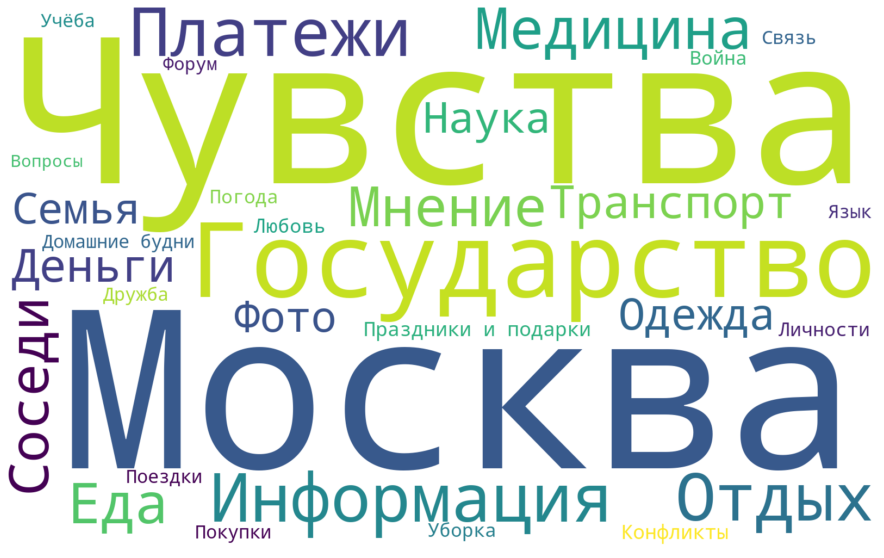

In [22]:
topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name='Final')
wordmap_df = topics_df[['First Word','Size']].groupby(['First Word'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['First Word'], wordmap_df['Size']))
wc = topics_size_word_map(wordmap_dict,   width=1600, height=1000)

In [ ]:
wc.to_file(TopicsSizeWordCloud_full_filename)

In [36]:
reduced_topics_df=ReducedTopicsData(model,num_topics=num_reduced)

In [30]:
model_coherence(model, data, reduced=True,num_topics=num_reduced)

0.5878865126519286

In [37]:
reduced_topics_df

Id  ...             Name
0    0  ...        гражданин
1    1  ...             сайт
2    2  ...           оплата
3    3  ...             врач
4    4  ...        фестиваль
5    5  ...              чай
6    6  ...          человек
7    7  ...            сосед
8    8  ...            метро
9    9  ...            доход
10  10  ...             глаз
11  11  ...           одежда
12  12  ...             отец
13  13  ...           учёный
14  14  ...         фотограф
15  15  ...          подарок
16  16  ...           собака
17  17  ...           любовь
18  18  ...        известный
19  19  ...            кухня
20  20  ...           погода
21  21  ...            война
22  22  ...            спать
23  23  ...           турция
24  24  ...      образование
25  25  ...            номер
26  26  ...     русский_язык
27  27  ...         общаться
28  28  ...          заранее
29  29  ...            город
30  30  ...          магазин
31  31  ...  правило_легенда
32  32  ...         ссылочка
33  33  ...             парк
34  34  ...            жизнь

[35 rows x 6 columns]

In [38]:
SaveToExperimentLog(Experiments_file,'Final',reduced_topics_df)

In [51]:
reduced_topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=tab_adj_data)
reduced_topics_df.head()

Id  Size  ...                 Name_eng First Word eng
0   0  2063  ...     State and Government          State
1   1  2035  ...              Information    Information
2   2  2028  ...                 Payments       Payments
3   3  1760  ...         Medical Problems       Medicine
4   4  1705  ...  Cultural life in Moscow         Moscow

[5 rows x 10 columns]

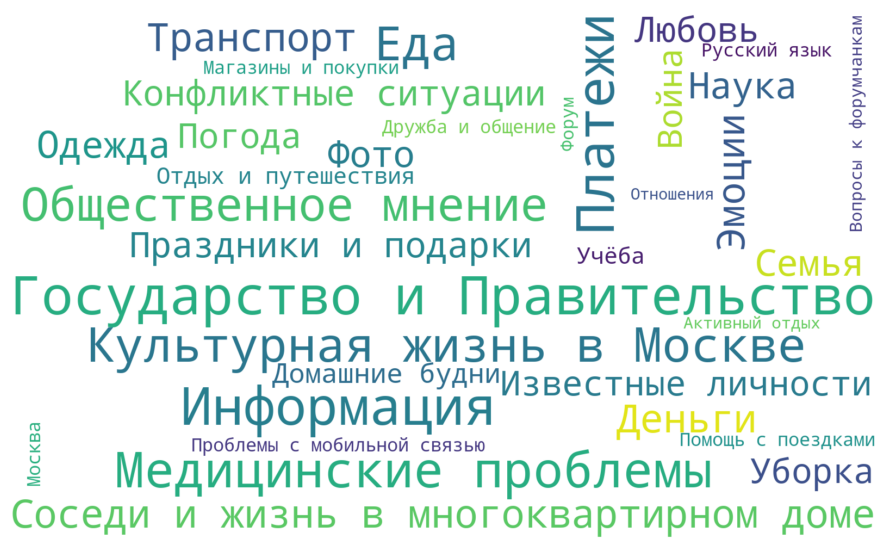

In [52]:
wordmap_df = reduced_topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))

wc = topics_size_word_map(wordmap_dict,   width=1600, height=1000)
#wc.to_file(TopicsSizeWordCloud_full_filename)

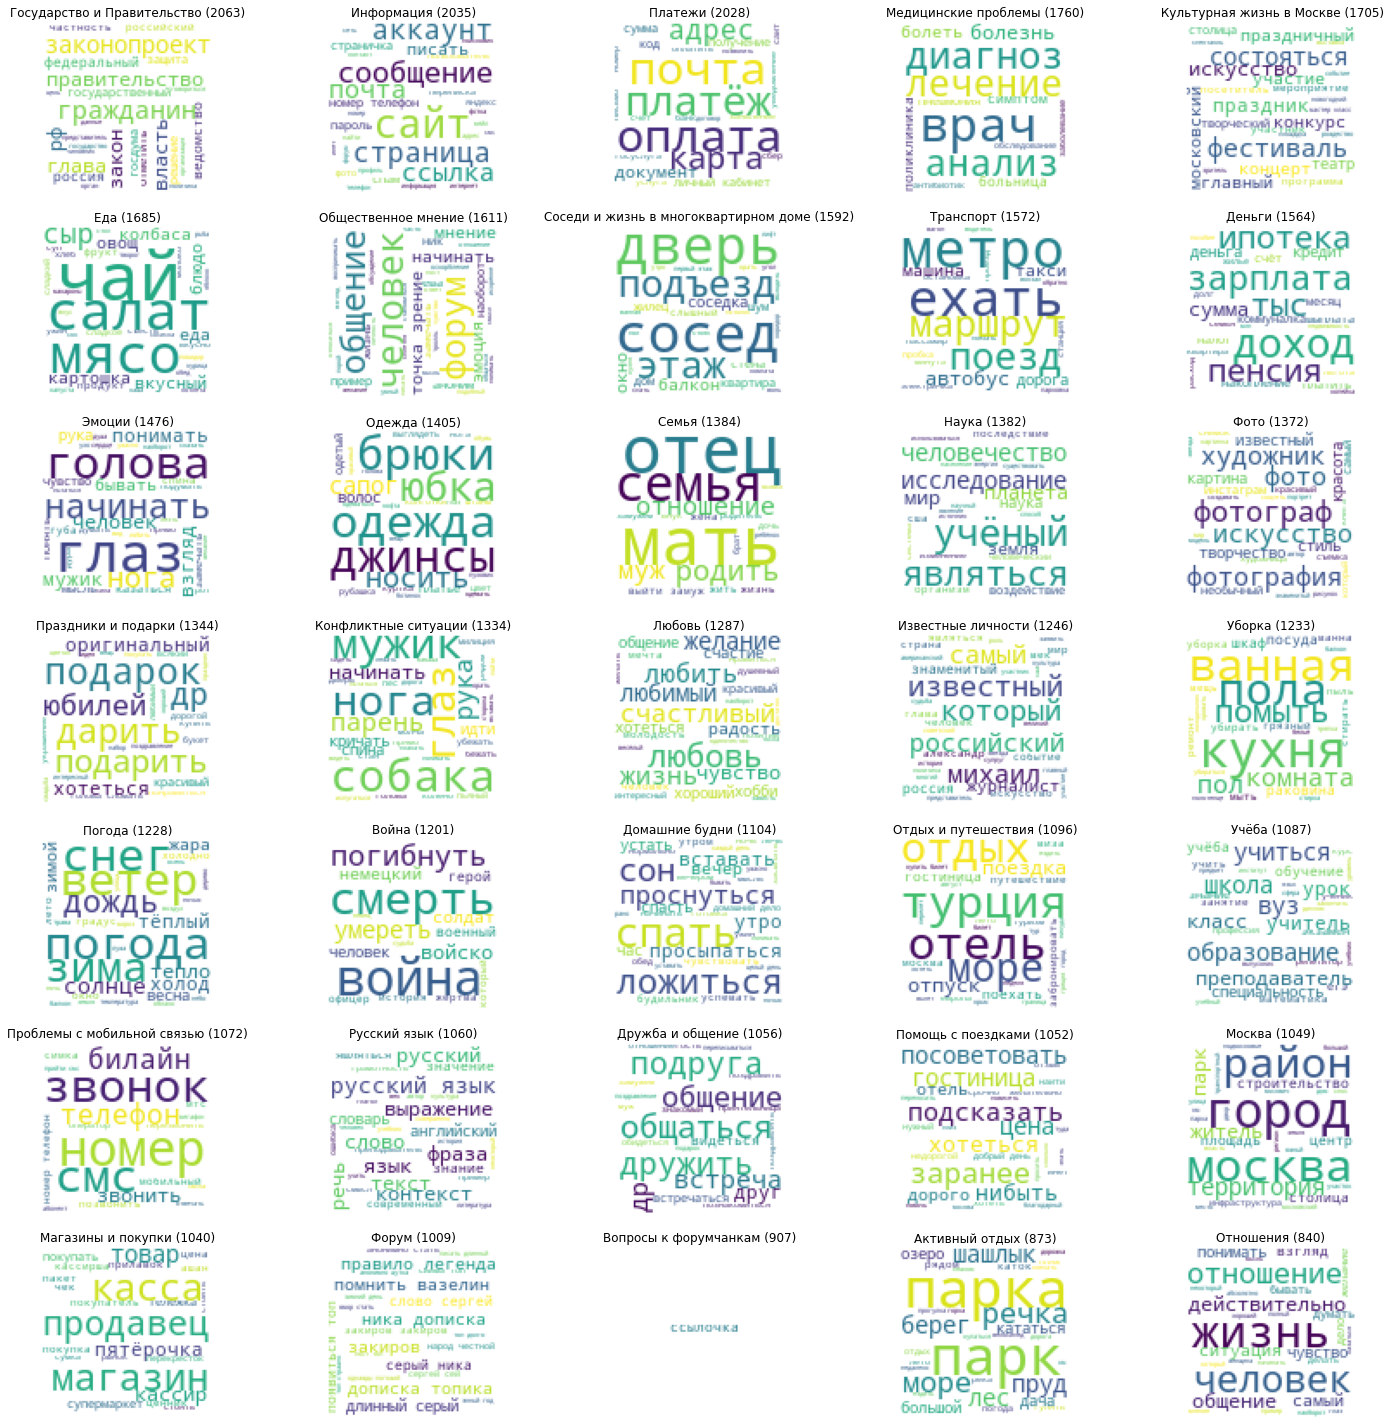

In [53]:
fig = topics_content_word_map(model,reduced=True, nrows=7, ncols=5,  width=100, height=100, width_figsize=20, height_figsize=20, topic_names=reduced_topics_df['Name'].tolist())
fig.savefig(TopicsContentWordCloud_full_filename)

In [54]:
topics_distance_map(model,  reduced=True,   width = 650, height = 650, topic_names=reduced_topics_df['Name'].tolist())

In [55]:
fig=topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name'].tolist())
fig.write_html(Distancemap_full_filename)

In [56]:
visualize_heatmap(model,n_clusters=8, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name'].tolist())

In [57]:
fig=visualize_heatmap(model,n_clusters=3, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name'].tolist())
fig.write_html(Heatmap_full_filename)

# Translate to English

In [ ]:
!pip install transformers

In [39]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer

In [40]:
mname = "facebook/wmt19-ru-en"

In [41]:
tokenizer = FSMTTokenizer.from_pretrained(mname)
translation_model = FSMTForConditionalGeneration.from_pretrained(mname)

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/387k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

In [42]:
def ToEnglish(row,column):
    input = row[column]
    input_ids = tokenizer.encode(input, return_tensors="pt")
    outputs = translation_model.generate(input_ids)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [43]:
reduced_topics_df['Words_eng'] = reduced_topics_df.apply(lambda x: ToEnglish(x, 'Words'), axis=1)

In [44]:
reduced_topics_df['Name_eng'] = reduced_topics_df.apply(lambda x: ToEnglish(x, 'Name'), axis=1)

In [45]:
reduced_topics_df['First Word eng'] = reduced_topics_df.apply(lambda x: ToEnglish(x, 'First Word'), axis=1)

In [58]:
reduced_topics_df

Id  Size  ...                                    Name_eng      First Word eng
0    0  2063  ...                        State and Government               State
1    1  2035  ...                                 Information         Information
2    2  2028  ...                                    Payments            Payments
3    3  1760  ...                            Medical Problems            Medicine
4    4  1705  ...                     Cultural life in Moscow              Moscow
5    5  1685  ...                                        Food                Food
6    6  1611  ...                              Public opinion             Opinion
7    7  1592  ...  Neighbors and life in an apartment complex           Neighbors
8    8  1572  ...                                   Transport           Transport
9    9  1564  ...                                       Money               Money
10  10  1476  ...                                    Emotions            Emotions
11  11  1405  ...                                    Clothing            Clothing
12  12  1384  ...                                      Family              Family
13  13  1382  ...                                     Science             Science
14  14  1372  ...                                       Photo               Photo
15  15  1344  ...                          Holidays and gifts  Holidays and gifts
16  16  1334  ...                         Conflict situations           Conflicts
17  17  1287  ...                                        Love                Love
18  18  1246  ...                                 Celebrities         Celebrities
19  19  1233  ...                                    Cleaning            Cleaning
20  20  1228  ...                                     Weather             Weather
21  21  1201  ...                                         War                TWar
22  22  1104  ...                               Everyday life       Everyday life
23  23  1096  ...                        Vacations and travel           Vacations
24  24  1087  ...                                       Study               Study
25  25  1072  ...         Problems with mobile communications      Communications
26  26  1060  ...                            Russian language            Language
27  27  1056  ...                Friendship and communication          Friendship
28  28  1052  ...                           Travel assistance              Travel
29  29  1049  ...                                      Moscow              Moscow
30  30  1040  ...                                    Shopping            Shopping
31  31  1009  ...                                       Forum               Forum
32  32   907  ...                  Questions to forum members           Questions
33  33   873  ...                         Recreation activity          Recreation
34  34   840  ...                               Relationships       Relationships

[35 rows x 10 columns]

In [47]:
SaveToExperimentLog(Experiments_file,'Final',reduced_topics_df)

In [59]:
reduced_topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=tab_adj_data)
reduced_topics_df.head()

Id  Size  ...                 Name_eng First Word eng
0   0  2063  ...     State and Government          State
1   1  2035  ...              Information    Information
2   2  2028  ...                 Payments       Payments
3   3  1760  ...         Medical Problems       Medicine
4   4  1705  ...  Cultural life in Moscow         Moscow

[5 rows x 10 columns]

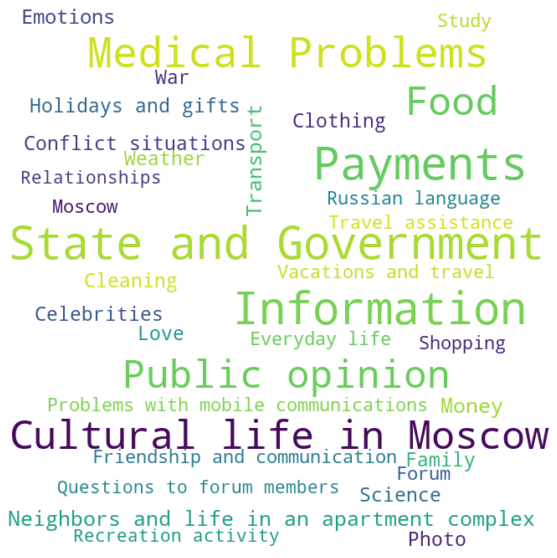

In [60]:
wordmap_df = reduced_topics_df[['Name_eng','Size']].groupby(['Name_eng'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['Name_eng'], wordmap_df['Size']))
wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
#wc.to_file(TopicsSizeWordCloud_full_filename)

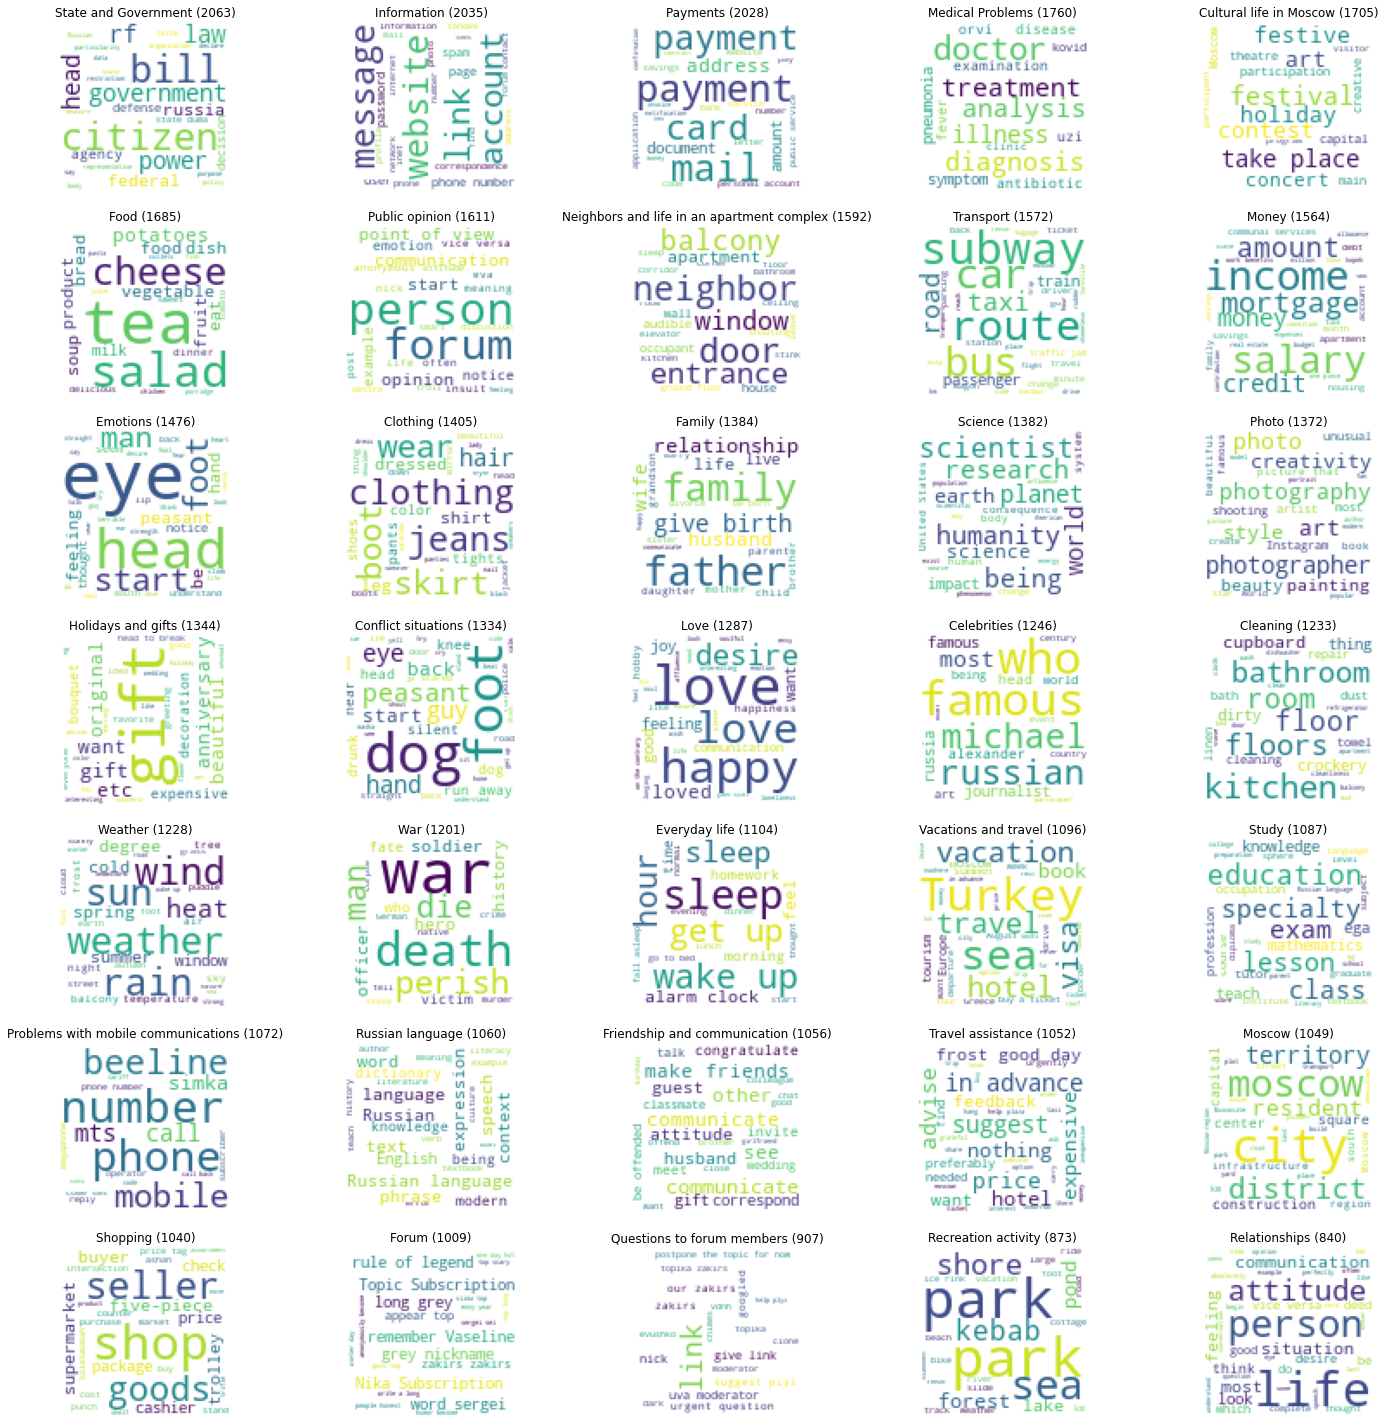

In [61]:
topic_content=reduced_topics_df['Words_eng'].str.split(',').tolist()
fig = topics_content_word_map(model,reduced=True, nrows=7, ncols=5,  width=100, height=100, width_figsize=20, height_figsize=20,topic_content=topic_content, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.savefig(TopicsContentWordCloud_full_filename_eng)

In [62]:
topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name_eng'].tolist())

In [63]:
fig=topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.write_html(Distancemap_full_filename_eng)

In [65]:
visualize_heatmap(model,n_clusters=8, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name_eng'].tolist())

In [66]:
fig=visualize_heatmap(model,n_clusters=7, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.write_html(Heatmap_full_filename_eng)

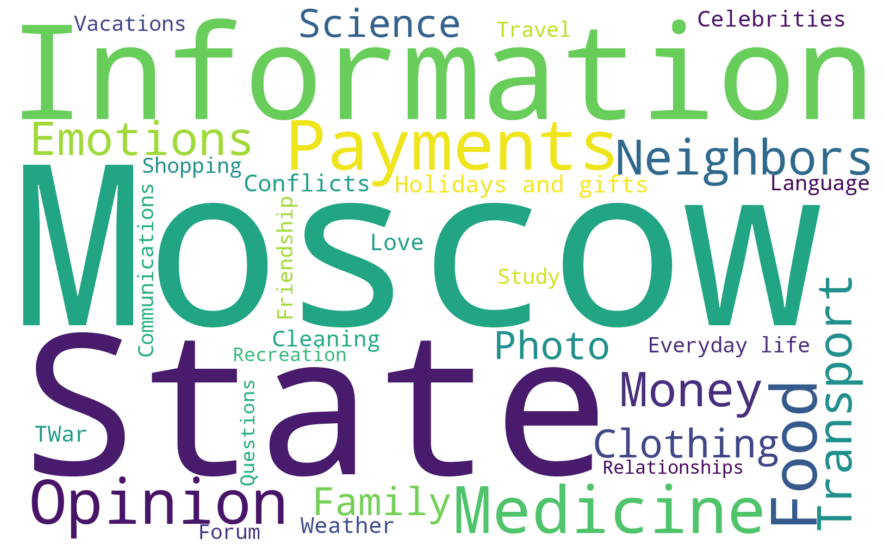

In [69]:
topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name='Final')
wordmap_df = topics_df[['First Word eng','Size']].groupby(['First Word eng'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['First Word eng'], wordmap_df['Size']))
wc = topics_size_word_map(wordmap_dict,   width=1600, height=1000)

In [70]:
wc.to_file(TopicsSizeWordCloud_full_filename_eng)